# How to Pivot and Plot Data With Pandas

A big challenge of working with data is manipulating its format for the analysis at hand. To make things more difficult, the "proper format" can depend on what you are trying to analyze, meaning we have to know how to melt, pivot, and transpose our data. In this article, we will learn how to create a pivot table of aggregated data in order to make a stacked bar visualization of 2019 airline market share for the top 10 destination cities. All the code for this analysis is available on GitHub here (link TBD) and can also be run using this (link TBD) Binder environment.

We will be using 2019 flight statistics from the Bureau of Transportation Statistics (available [here](https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FMF&QO_fu146_anzr=Nv4%20Pn44vr45)). It contains 321,409 rows and 41 columns:

In [ ]:
import pandas as pd

df = pd.read_csv('../865214564_T_T100_MARKET_ALL_CARRIER.zip')
df.shape

Each row contains monthly-aggregated information on flights operated by a variety of airline carriers, including passenger and cargo service. Note that the columns are all in uppercase at the moment:

In [2]:
df.columns

Index(['PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'UNIQUE_CARRIER',
       'AIRLINE_ID', 'UNIQUE_CARRIER_NAME', 'UNIQUE_CARRIER_ENTITY', 'REGION',
       'CARRIER', 'CARRIER_NAME', 'CARRIER_GROUP', 'CARRIER_GROUP_NEW',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_COUNTRY', 'ORIGIN_COUNTRY_NAME',
       'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_COUNTRY', 'DEST_COUNTRY_NAME',
       'DEST_WAC', 'YEAR', 'QUARTER', 'MONTH', 'DISTANCE_GROUP', 'CLASS',
       'DATA_SOURCE'],
      dtype='object')

To make the data easier to work with, we will transform the column names into lowercase using the `rename()` method:

In [3]:
df = df.rename(lambda x: x.lower(), axis=1)
df.head()

,passengers,freight,mail,distance,unique_carrier,airline_id,unique_carrier_name,unique_carrier_entity,region,carrier,...,dest_state_nm,dest_country,dest_country_name,dest_wac,year,quarter,month,distance_group,class,data_source
0,0.0,53185.0,0.0,8165.0,EK,20392,Emirates,9678A,I,EK,...,Texas,US,United States,74,2019,1,3,17,G,IF
1,0.0,9002.0,0.0,6849.0,EK,20392,Emirates,9678A,I,EK,...,New York,US,United States,22,2019,1,3,14,G,IF
2,0.0,2220750.0,0.0,7247.0,EK,20392,Emirates,9678A,I,EK,...,Illinois,US,United States,41,2019,1,3,15,G,IF
3,0.0,1201490.0,0.0,8165.0,EK,20392,Emirates,9678A,I,EK,...,NaN,AE,United Arab Emirates,678,2019,1,3,17,G,IF
4,0.0,248642.0,0.0,6849.0,EK,20392,Emirates,9678A,I,EK,...,NaN,AE,United Arab Emirates,678,2019,1,3,14,G,IF


For our analysis, we want to look at passenger airlines to find the market share in 2019 among the top 5 carriers (based on total number of passengers in 2019). To do so, we first need to figure out which carriers were in the top 5. Remember, the data contains information on all types of flights, but we only want passenger flights, so we first query `df` for flights marked `F` in the `class` column (note that we need backticks to reference this column because `class` is a reserved keyword). Then, we group by the carrier name and sum each carrier's passenger counts. Finally, we call the `nlargest()` method to return only the top 5:

In [7]:
# download flight class meanings at
# https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_fReiVPR_PYNff
top_airlines = df.query('`class` == "F"')\
    .groupby('unique_carrier_name').passengers.sum()\
    .nlargest(5)
top_airlines

unique_carrier_name
Southwest Airlines Co.    162681011.0
Delta Air Lines Inc.      162260114.0
American Airlines Inc.    155782611.0
United Air Lines Inc.     116212143.0
JetBlue Airways            42830602.0
Name: passengers, dtype: float64

Note that the top 5 airlines also run flights of a different class, so we can't remove this filter for the rest of our analysis:

In [8]:
df.loc[
    df.unique_carrier_name.isin(top_airlines.index), 'class'
].value_counts()

F    97293
L     3994
Name: class, dtype: int64

Now, we can create the pivot table; however, we cannot filter down to the top 5 airlines just yet, because, in order to get market share, we need to know the numbers for the other airlines as well. Therefore, we will build a pivot table that calculates the total number of passengers each airline flew to each destination city. To do so, we specify that we want the following in our call to the `pivot_table()` method:

- Unique values in the `dest_city_name` column should be used as our row labels (the `index` argument)
- Unique values in the `unique_carrier_name` column should be used as our column labels (the `columns` argument)
- The values used for the aggregation should come from the `passengers` column (the `values` argument), and they should be summed (the `aggfunc` argument)
- Row/column subtotals should be calculated (the `margins` argument)

Finally, since we want to look at the top 10 destinations, we will sort the data in descending order using the `All` column, which contains the total passengers flown to each city in 2019 for all carriers combined (this was created by passing in `margins=True` in the call to the `pivot_table()` method):

In [9]:
pivot = df.query('`class` == "F"').pivot_table(
    index='dest_city_name', 
    columns='unique_carrier_name', 
    values='passengers',
    aggfunc='sum', 
    margins=True
).sort_values('All', ascending=False)
pivot.head(10)

unique_carrier_name,40-Mile Air,ABC Aerolineas SA de CV dba Interjet,"ADVANCED AIR, LLC",Aer Lingus Plc,"Aeroenlaces Nacionales, S.A. de C.V. d/b/a VivaAerobus",Aeroflot Russian Airlines,Aerolineas Argentinas,Aerolitoral,Aeromexico,Aerovias Nacl De Colombia,...,Virgin Atlantic Airways,Virgin Blue International Airlines t/a V Australia,"Vuela Aviacion, S.A.",WOW Air ehf,Warbelow,Westjet,Wright Air Service,XL Airways France,"Xiamen Airlines Co., Ltd.",All
dest_city_name,,,,,,,,,,,,,,,,,,,,,
All,502.0,2249942.0,27049.0,2396297.0,503660.0,893421.0,406959.0,767266.0,2660861.0,1796877.0,...,4139847.0,507699.0,170673.0,46485.0,4414.0,5273827.0,58652.0,196530.0,265158.0,1.052983e+09
"Atlanta, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,42332.0,NaN,NaN,...,166993.0,NaN,NaN,NaN,NaN,45398.0,NaN,NaN,NaN,5.354563e+07
"Chicago, IL",NaN,134049.0,NaN,175630.0,5189.0,NaN,NaN,NaN,183061.0,5998.0,...,203.0,NaN,NaN,2801.0,NaN,NaN,NaN,NaN,NaN,5.109597e+07
"New York, NY",NaN,150680.0,NaN,243337.0,46497.0,277853.0,64696.0,28660.0,217652.0,238556.0,...,589804.0,NaN,18722.0,NaN,NaN,309748.0,NaN,17582.0,39095.0,4.667482e+07
"Los Angeles, CA",NaN,226119.0,0.0,73206.0,66846.0,98407.0,NaN,42672.0,281284.0,76943.0,...,171369.0,250857.0,45140.0,1999.0,NaN,371214.0,NaN,17016.0,67388.0,4.285396e+07
"Dallas/Fort Worth, TX",NaN,75046.0,NaN,NaN,NaN,NaN,NaN,44437.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.583777e+07
"Denver, CO",NaN,NaN,NaN,NaN,NaN,NaN,NaN,660.0,18101.0,NaN,...,NaN,NaN,NaN,NaN,NaN,18151.0,NaN,NaN,NaN,3.359168e+07
"Houston, TX",NaN,107018.0,NaN,NaN,50053.0,NaN,NaN,72805.0,2780.0,NaN,...,NaN,NaN,NaN,NaN,NaN,61949.0,NaN,NaN,NaN,2.897363e+07
"San Francisco, CA",NaN,59014.0,NaN,91075.0,NaN,NaN,NaN,NaN,171296.0,NaN,...,144379.0,NaN,NaN,NaN,NaN,75104.0,NaN,11059.0,NaN,2.788376e+07


Notice that the first row in the previous result is the subtotal by airline and not a city, so we will drop that row before selecting the first 10 rows of the sorted data:

In [10]:
pivot = pivot.drop('All').head(10)

Selecting the columns for the top 5 airlines now gives us the number of passengers that each airline flew to the top 10 cities. Note that we use `sort_index()` so that the resulting columns are displayed in alphabetical order:

In [11]:
pivot[top_airlines.sort_index().index]

unique_carrier_name,American Airlines Inc.,Delta Air Lines Inc.,JetBlue Airways,Southwest Airlines Co.,United Air Lines Inc.
dest_city_name,,,,,
"Atlanta, GA",1408293.0,39316060.0,379978.0,4532294.0,464029.0
"Chicago, IL",9765334.0,1630202.0,243332.0,9467759.0,12487875.0
"New York, NY",5679066.0,11018205.0,7856711.0,1455566.0,1057162.0
"Los Angeles, CA",7066848.0,6490402.0,975568.0,4840787.0,5032208.0
"Dallas/Fort Worth, TX",24398889.0,1166353.0,83249.0,NaN,702076.0
"Denver, CO",1515364.0,1707589.0,182436.0,9279814.0,10625467.0
"Houston, TX",1022137.0,747316.0,89390.0,6627678.0,11500414.0
"San Francisco, CA",1979323.0,2160946.0,715299.0,1608102.0,10803363.0
"Seattle, WA",1187459.0,4906617.0,276241.0,1446404.0,1383381.0


Our data is now in the right format for a stacked bar plot showing passenger counts. To make this visualization, we call the `plot()` method on the previous result and specify that we want horizontal bars (`kind='barh'`) and that the different airlines should be stacked (`stacked=True`). Note that since we have the destinations sorted in descending order, Atlanta will be plotted on the bottom, so we call `invert_yaxis()` on the `Axes` object returned by `plot()` to flip the order:

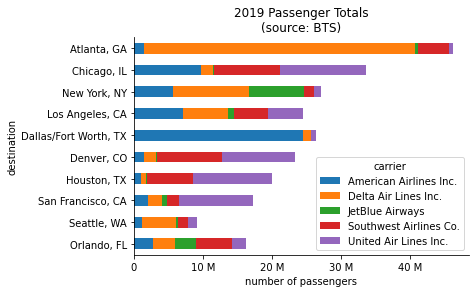

In [17]:
from matplotlib import ticker

ax = pivot[top_airlines.sort_index().index].plot(
    kind='barh', stacked=True, 
    title='2019 Passenger Totals\n(source: BTS)'
)
ax.invert_yaxis() # put destinations with more passengers on top

# formatting
ax.set(xlabel='number of passengers', ylabel='destination')
ax.legend(title='carrier')

# shows x-axis in millions instead of scientific notation
ax.xaxis.set_major_formatter(ticker.EngFormatter())

# removes the top and right lines from the figure to make it less boxy
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

One interesting thing to notice from the previous result is that Seattle is a top 10 destination, yet the top 5 carriers don't appear to be contributing as much to it as the rest of the destination cities, which are pretty much in the same order with the exception of Los Angeles. This could cause some confusion, so let's add in another stacked bar called `Other` that contains the passenger totals for all airlines not in the top 5. Since we calculated the `All` column when we created the pivot table, all we have to do here is add a column to our filtered data that contains the `All` column minus the top 5 airlines' passenger totals summed together. The plotting code only needs to be modified to shift the legend further out:

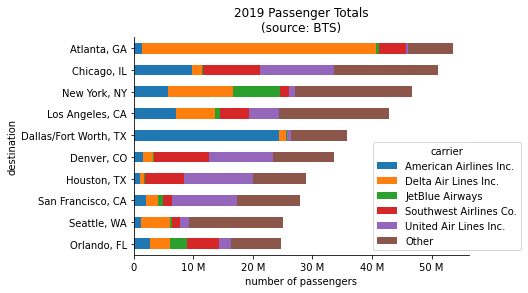

In [23]:
ax = pivot[top_airlines.sort_index().index].assign(
    Other=lambda x: pivot.All - x.sum(axis=1)
).plot(
    kind='barh', stacked=True, 
    title='2019 Passenger Totals\n(source: BTS)'
)
ax.invert_yaxis()

# formatting
ax.set(xlabel='number of passengers', ylabel='destination')
ax.legend(title='carrier', bbox_to_anchor=(0.7, 0), loc='lower left') # shift to not cover the bars
ax.xaxis.set_major_formatter(ticker.EngFormatter())

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

We can now clearly see that Atlanta had the most passengers arriving in 2019 and that flights from Delta Air Lines were the biggest contributor, but we can do better by representing market share as percentage of all passengers arriving in each destination city. In order to do that, we need to modify our pivot table by dividing each airline's passenger counts by the `All` column:

In [19]:
normalized_pivot = pivot[top_airlines.sort_index().index].apply(lambda x: x / pivot.All)
normalized_pivot

unique_carrier_name,American Airlines Inc.,Delta Air Lines Inc.,JetBlue Airways,Southwest Airlines Co.,United Air Lines Inc.
dest_city_name,,,,,
"Atlanta, GA",0.026301,0.734253,0.007096,0.084644,0.008666
"Chicago, IL",0.191118,0.031905,0.004762,0.185294,0.244400
"New York, NY",0.121673,0.236063,0.168329,0.031185,0.022650
"Los Angeles, CA",0.164905,0.151454,0.022765,0.112960,0.117427
"Dallas/Fort Worth, TX",0.680815,0.032545,0.002323,NaN,0.019590
"Denver, CO",0.045111,0.050834,0.005431,0.276253,0.316312
"Houston, TX",0.035278,0.025793,0.003085,0.228749,0.396927
"San Francisco, CA",0.070985,0.077498,0.025653,0.057672,0.387443
"Seattle, WA",0.047339,0.195605,0.011013,0.057662,0.055149


Before plotting, we will also sort the bars by the total market share of the top 5 carriers. Viewing this information as percentages gives us a better idea of which carriers dominate which markets: Delta has by far the largest share of Atlanta and American Airlines has over 60% of Dallas/Fort Worth, while United has strong footholds in several markets:

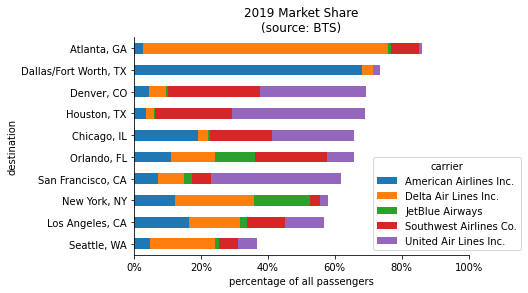

In [21]:
market_share_sorted = normalized_pivot.sum(axis=1).sort_values() # determine sort order

ax = normalized_pivot.loc[market_share_sorted.index,:].plot(
    kind='barh', stacked=True, xlim=(0, 1), 
    title='2019 Market Share\n(source: BTS)'
)

# formatting
ax.set(xlabel='percentage of all passengers', ylabel='destination')
ax.legend(title='carrier', bbox_to_anchor=(0.7, 0), loc='lower left')

# show x-axis as percentages
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
import matplotlib.pyplot as plt
plt.savefig('fig_07.png', bbox_inches='tight')

As we noticed earlier, Seattle sticks out. The top 5 carriers have more than 50% combined market share for 9 out of the top 10 destinations, but not for Seattle. Using our pivot table, we can see that Alaska Airlines is the top carrier for Seattle:

In [107]:
pivot.loc['Seattle, WA', :].nlargest(6)

unique_carrier_name
All                       25084302.0
Alaska Airlines Inc.       9637977.0
Delta Air Lines Inc.       4906617.0
Horizon Air                2454491.0
Southwest Airlines Co.     1446404.0
United Air Lines Inc.      1383381.0
Name: Seattle, WA, dtype: float64

Now, it's your turn. We only used a small subset of the columns, but this dataset is packed with information that can be analyzed with a pivot table: try looking into origin cities, freight/mail carriers, or even flight distance.

In this article, we explored just a few of the many powerful features in the `pandas` library that make data analysis easier. Be sure to check out my ODSC talk, "[Introduction to Data Analysis Using Pandas](https://odsc.com/speakers/introduction-to-data-analysis-using-pandas/)", for an in-depth introduction to `pandas`, and my book, "[Hands-On Data Analysis with Pandas](https://www.amazon.com/Hands-Data-Analysis-Pandas-visualization-dp-1800563450/dp/1800563450/)", for a thorough exploration of the `pandas` library using real-world datasets, along with `matplotlib`, `seaborn`, and `scikit-learn`.